Deep Reinforcement Learning

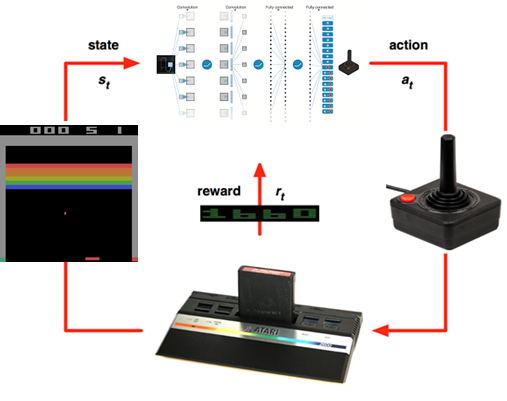

In [ ]:
%tensorflow_version 2.x

!pip install keras-rl2
#!apt-get install -y cmake zlib1g-dev libjpeg-dev xvfb ffmpeg xorg-dev python-opengl libboost-all-dev libsdl2-dev swig
!wget https://github.com/kenwkliu/ideas/raw/master/colab/data/dqn_BreakoutDeterministic-v4_weights_1750000.h5f
!wget https://github.com/kenwkliu/ideas/raw/master/colab/data/BreakoutDeterministic-v4.bin
!wget https://github.com/kenwkliu/ideas/raw/master/colab/data/MsPacman-v0.bin

!python -m atari_py.import_roms .

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
from PIL import Image
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Convolution2D, Permute
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

import gym
from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint
from rl.callbacks import Callback

class AtariProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')

    def process_state_batch(self, batch):
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

# Subclass to visualize on Jupyter Notebook, inherits from rl.callbacks.Callback Class
class Render(Callback):
    def on_step_end(self, step, logs={}):
        plt.clf()
        plt.imshow(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)

SIZE_X, SIZE_Y = 12, 7.5

In [ ]:
# Initial a "Breakout" game from OpenAI gym
ENV_NAME = 'BreakoutDeterministic-v4'
env = gym.make(ENV_NAME)
env.reset()
print('Breakout game init from OpenAI gym')

In [ ]:
# Show possible Actions
print("Action : 0=no, 1=start, 2=right, 3=left")

# Show the result after each action
obs, reward, done, info = env.step(3)
print("Reward:",reward, "  Completed:",done, "  Info:",info)

plt.figure(figsize=(SIZE_X, SIZE_Y))
plt.imshow(obs)

In [ ]:
INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4

nb_actions = env.action_space.n
input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE

model = Sequential()
model.add(Permute((2, 3, 1), input_shape=input_shape))
model.add(Convolution2D(32, (8, 8), strides=(4, 4)))
model.add(Activation('relu'))
model.add(Convolution2D(64, (4, 4), strides=(2, 2)))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), strides=(1, 1)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)
processor = AtariProcessor()
callbacks = Render()

policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05,
                              nb_steps=1000000)

dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy, memory=memory,
               processor=processor, nb_steps_warmup=50000, gamma=.99, target_model_update=10000,
               train_interval=4, delta_clip=1.)

dqn.compile(Adam(lr=.00025), metrics=['mae'])

In [ ]:
# Train the model and display the results
plt.figure(figsize=(SIZE_X, SIZE_Y))
dqn.fit(env, nb_steps=3000, log_interval=1000)
dqn.test(env, nb_episodes=1, visualize=False, callbacks=[callbacks])

In [ ]:
# Load and use a pre-trained weightes (after 1.7 million times of training)
plt.figure(figsize=(SIZE_X, SIZE_Y))
weights_filename = 'dqn_BreakoutDeterministic-v4_weights_1750000.h5f'
dqn.load_weights(weights_filename)
dqn.test(env, nb_episodes=1, visualize=False, callbacks=[callbacks])

In [ ]:
# Pacman Game
ENV_NAME = 'MsPacman-v0'
env = gym.make(ENV_NAME)

In [ ]:
# Pacman Game
ENV_NAME = 'MsPacman-v0'
env = gym.make(ENV_NAME)

nb_actions = env.action_space.n
input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE

model = Sequential()
model.add(Permute((2, 3, 1), input_shape=input_shape))
model.add(Convolution2D(32, (8, 8), strides=(4, 4)))
model.add(Activation('relu'))
model.add(Convolution2D(64, (4, 4), strides=(2, 2)))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), strides=(1, 1)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)
processor = AtariProcessor()
callbacks = Render()

policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05,
                              nb_steps=1000000)

dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy, memory=memory,
               processor=processor, nb_steps_warmup=50000, gamma=.99, target_model_update=10000,
               train_interval=4, delta_clip=1.)

dqn.compile(Adam(lr=.00025), metrics=['mae'])

In [ ]:
# Train the model and display the results
plt.figure(figsize=(SIZE_X, SIZE_Y))
dqn.fit(env, nb_steps=3000, log_interval=1000)
dqn.test(env, nb_episodes=1, visualize=False, callbacks=[callbacks])